In [111]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
tokenizer = AutoTokenizer.from_pretrained("yanekyuk/bert-uncased-keyword-extractor")

In [113]:
input_ids = tokenizer("front", return_tensors="pt", truncation=True)
input_ids

# dictionary with 3 keys - ids, toekn_type_ids and attention mask

{'input_ids': tensor([[ 101, 2392,  102]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

In [61]:
input_ids = tokenizer.encode("front", add_special_tokens=False, return_tensors="pt")
input_ids.detach().numpy()[0][0]

2392

In [114]:
df = pd.read_csv("Relnet_data2.csv")
df

,words,x,y,z
0,approach,1,0,0
1,ascend,1,0,0
2,descend,-1,0,0
3,direct,1,0,0
4,enter,1,0,0
...,...,...,...,...
67,straight,1,0,0
68,there,0,0,0
69,underfoot,0,0,0
70,upwards,0,0,0


In [115]:
def tokenized(x):
    input_ids = tokenizer.encode(x, add_special_tokens=False, return_tensors="pt").detach().numpy()[0][0]
    return input_ids

def randomised(x):
    if x == 99:
        x = np.random.rand()
    return x
        
df["words"] = df["words"].apply(tokenized)
df["x"] = df["x"].apply(randomised)
df["y"] = df["y"].apply(randomised)
df["z"] = df["z"].apply(randomised)
df

,words,x,y,z
0,3921,1.00000,0.0,0.0
1,2004,1.00000,0.0,0.0
2,18855,-1.00000,0.0,0.0
3,3622,1.00000,0.0,0.0
4,4607,1.00000,0.0,0.0
...,...,...,...,...
67,3442,1.00000,0.0,0.0
68,2045,0.00000,0.0,0.0
69,2104,0.00000,0.0,0.0
70,14873,0.00000,0.0,0.0


In [123]:
X = df["words"].to_frame()
x = df["x"].to_frame()
y = df["y"]
z = df["z"]

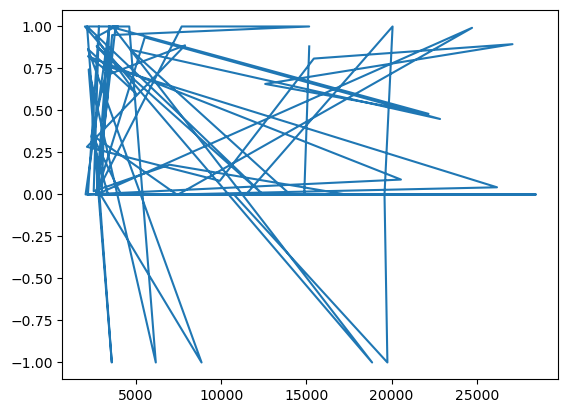

In [132]:
import matplotlib.pyplot as plt
plt.plot(X,x)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, x,random_state=42)

regr = MLPRegressor(random_state=42, max_iter=500).fit(X_train, y_train)
regr.predict(X_test[:2])

regr.score(X_test, y_test)

/home/ImMusic/.conda/envs/dreamfusion/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-2483.392269973483

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

texts = []
labels = []


word_to_idx = {}
for text in texts:
    for word in text.split():
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
print("Vocabulary size:", len(word_to_idx))

def text_to_tensor(text):
    tensor = torch.zeros(len(text), dtype=torch.long)
    for i, word in enumerate(text.split()):
        tensor[i] = word_to_idx[word]
    return tensor

X = [text_to_tensor(text) for text in texts]
Y = [labels.index(label) for label in labels]
num_classes = len(set(Y))
print("Number of classes:", num_classes)


class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        h, _ = self.gru(x)
        h = h[:, -1, :]
        out = self.fc(h)
        return out

    
batch_size = 2
embedding_dim = 16
hidden_dim = 32
lr = 0.01
n_epochs = 50

model = TextClassifier(len(word_to_idx), embedding_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    running_loss = 0.0
    for i in range(0, len(X), batch_size):
        inputs = X[i:i+batch_size]
        labels = Y[i:i+batch_size]
        inputs_len = [len(seq) for seq in inputs]
        inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True)
        inputs = inputs.cuda()
        labels = torch.tensor(labels).cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / (len(X)/batch_size)
    print('Epoch %d loss: %.4f' % (epoch+1, epoch_loss))

test_texts = []
test_X = [text_to_tensor(text) for text in test_texts]
test_X_len = [len(seq) for seq in test_X]
test_X = nn.utils.rnn.pad_sequence(test_X, batch_first=True).cuda()
with torch.no_grad():
    test_outputs = model(test_X)
test_pred = test_outputs.argmax(dim=1).cpu().numpy()
test_labels = [labels[i] for i in test_pred]
print("Test predicted labels:", test_labels)
